In [25]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function

In [26]:
## I will create a dataset of one dimensional gaussian. Pass it through VAE and seee if the lateent space learns 
## the correct mu and sigma

def sample(mu, var, nb_samples):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [torch.normal(mu, var.sqrt())]
    return torch.stack(out, dim=0)

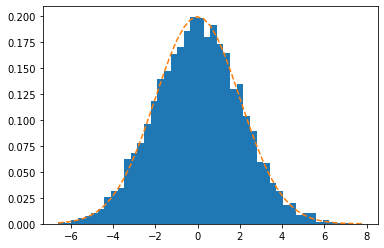

tensor(0.)
tensor(4.)


In [27]:
## Creating synthetic dataset
nb_samples=5000
mu  =torch.tensor(0.)   # . converts long to float
var =torch.tensor(4.0)
inp_data=sample(mu,var,nb_samples)
inp_data=inp_data.unsqueeze(0)
inp_data=torch.transpose(inp_data,0,1)
## for data visualization
inp_data_vis=inp_data.numpy()
n,bins,patches=plt.hist(inp_data_vis,'auto',density=1)
y=1/(np.sqrt(2*np.pi*var))*np.exp(-0.5*(bins-mu.numpy())**2/var)
plt.plot(bins,y,'--')
plt.show()
print(mu)
print(var)

In [28]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 4 
fun_A   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
data    = inp_data*fun_A

In [16]:
## Hyperparameters
epochs     = 40
batch_size = 64
lr         = 1e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [17]:
## Creating synthetic dataloader

train_loader = DataLoader(
    data[0:int(0.8*nb_samples),],   ## 80% of data used for training
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader = DataLoader(
    data[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [18]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)

latent_dim = 1
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        ## Encoder
        self.enc1 = nn.Linear(in_features = dim_exp,out_features = 64)
        self.enc2 = nn.Linear(in_features = 64     ,out_features = 32)
        self.enc3 = nn.Linear(in_features = 32     ,out_features = 2 )

        ## Decoder
        self.dec1 = nn.Linear(in_features = 1      ,out_features = dim_exp)
        self.dec2 = nn.Linear(in_features = 1      ,out_features = dim_exp)

    def reparameterize(self,mu,log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z   = mu+eps*std
        return z
    def forward(self,x):
        ## encoding
        x       = F.relu(self.enc1(x))
        x       = F.relu(self.enc2(x))
        x       = self.enc3(x)
        ## reparametrization        
        mu      = x[:,0]
        log_var = x[:,1]
        z       = self.reparameterize(mu,log_var)
        z       = z.unsqueeze(0)
        z       = torch.transpose(z,0,1)

        ## decoding
        mu_out = self.dec1(z)
        log_var_out = self.dec2(z)
        reconstruction  = self.reparameterize(mu_out,log_var_out)

        #reconstruction = (self.dec2(x))
        return mu,log_var,reconstruction

In [19]:
model = VAE().to(device)
#criterion = nn.BCELoss(reduction='sum')
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(),lr=lr)

In [20]:
def final_loss(mse_loss, mu, logvar):
    #MSE = nb_samples/batch_size*torch.sum(mse_loss/(2*var)+0.5*torch.log(2*np.pi*var))
    MSE = mse_loss

    KLD = 0.5 * (torch.sum(mu.pow(2) + logvar.exp()- logvar -1  ))
    return MSE + KLD

In [21]:
def train(model,dataloader):
    model.train()
    running_loss = 0
    for i,data in enumerate(dataloader):
        data                      = data.to(device)
        mu,log_var,reconstruction = model(data)
        bce_loss                  = criterion(reconstruction, data)
        loss                      = final_loss(bce_loss, mu, log_var)
        running_loss             += loss.item()
        loss.backward()                      
        optimizer.step()
    train_loss = running_loss/(len(dataloader.dataset))
    return train_loss
def test(model,dataloader):
    mean_pred = []
    var_pred  = []
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,data in enumerate(dataloader):
            data                      = data.to(device)
            mu,log_var,reconstruction = model(data)
            bce_loss                  = criterion(reconstruction, data)
            loss                      = final_loss(bce_loss, mu, log_var)
            running_loss             += loss.item()
            mean_pred                += [torch.mean(mu)]
            var_pred                 += [torch.mean(torch.exp(log_var))]
    test_loss = running_loss/(len(dataloader.dataset))
    mean_pred = torch.stack(mean_pred,dim=0)
    var_pred  = torch.stack(var_pred,dim=0)
    mean_pred = torch.mean(mean_pred)
    var_pred  = torch.mean(var_pred)
    return test_loss,mean_pred,var_pred

In [22]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader)
    test_epoch_loss,mean_pred,var_pred = test(model,test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
print(f"Train Loss: {train_epoch_loss:.4f}")
print(f"Test Loss:  {test_epoch_loss:.4f}")
print(f"Mean Pred:  {mean_pred:.4f}")
print(f"Var  Pred:  {var_pred:.4f}")   

Epoch 1 of 40
Epoch 2 of 40
Epoch 3 of 40
Epoch 4 of 40
Epoch 5 of 40
Epoch 6 of 40
Epoch 7 of 40
Epoch 8 of 40
Epoch 9 of 40
Epoch 10 of 40
Epoch 11 of 40
Epoch 12 of 40
Epoch 13 of 40
Epoch 14 of 40
Epoch 15 of 40
Epoch 16 of 40
Epoch 17 of 40
Epoch 18 of 40
Epoch 19 of 40
Epoch 20 of 40
Epoch 21 of 40
Epoch 22 of 40
Epoch 23 of 40
Epoch 24 of 40
Epoch 25 of 40
Epoch 26 of 40
Epoch 27 of 40
Epoch 28 of 40
Epoch 29 of 40
Epoch 30 of 40
Epoch 31 of 40
Epoch 32 of 40
Epoch 33 of 40
Epoch 34 of 40
Epoch 35 of 40
Epoch 36 of 40
Epoch 37 of 40
Epoch 38 of 40
Epoch 39 of 40
Epoch 40 of 40
Train Loss: 0.0861
Test Loss:  0.0919
Mean Pred:  -0.0648
Var  Pred:  1.0403


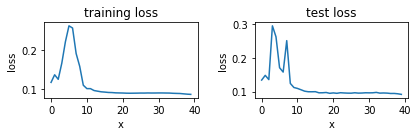

In [24]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

In [26]:
enc1 = nn.Linear(in_features = 1,out_features = 2)
print(data)
for parameter in enc1.parameters():
    print(parameter)
print(enc1(data))

tensor([[-0.1819],
        [ 0.5978],
        [-0.3839],
        [ 0.4683],
        [-0.3296]])
Parameter containing:
tensor([[-0.4732],
        [ 0.9657]], requires_grad=True)
Parameter containing:
tensor([ 0.7991, -0.2023], requires_grad=True)
tensor([[ 0.8851, -0.3780],
        [ 0.5161,  0.3751],
        [ 0.9807, -0.5730],
        [ 0.5774,  0.2500],
        [ 0.9550, -0.5206]], grad_fn=<AddmmBackward>)


In [173]:
enc1 = nn.Linear(in_features = 1,out_features = 2)
F.relu(enc1(data))

tensor([[0.0000, 0.0207],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        ...,
        [0.2933, 0.2515],
        [0.0000, 0.1351],
        [0.0179, 0.1819]], grad_fn=<ReluBackward0>)

In [424]:
A=list(model.named_parameters())[-1]
B=A[1].data.cpu()/fun_A.numpy()

In [425]:
B

tensor([[  3.9529,  -0.1571,  -0.2421,  ...,   0.1931,  -0.2942,   0.1499],
        [-14.5422,   0.5779,   0.8905,  ...,  -0.7103,   1.0824,  -0.5513],
        [ 10.4142,  -0.4139,  -0.6377,  ...,   0.5087,  -0.7751,   0.3948],
        ...,
        [ -5.4541,   0.2167,   0.3340,  ...,  -0.2664,   0.4059,  -0.2068],
        [ 15.9982,  -0.6358,  -0.9797,  ...,   0.7814,  -1.1907,   0.6065],
        [  2.8036,  -0.1114,  -0.1717,  ...,   0.1369,  -0.2087,   0.1063]])